# **Imports**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Benchmark**

In [ ]:
pip install ai-benchmark

     |████████████████████████████████| 21.6MB 1.4MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp37-none-any.whl size=20070 sha256=dbbf1e2af615e56ac15d138c9a56309ef7a22b0b62a2d36e6c34009c5aea85a5
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


# **Basic Functions**

In [ ]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.2)])

In [ ]:
# _input_fn function with data_augmentation

def _input_fn(x,y, BATCH_SIZE,augment):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
# train_model function

def train_model(model,callbacks,epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  start_time = time.time()
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps,callbacks=[callbacks])
  end_time = time.time() - start_time
  return history , end_time ;

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

# **Basic Notebook**

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [ ]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 2s 0us/step


In [ ]:
print(x_train_all.shape)

(50000, 32, 32, 3)


In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 154

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number()

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
print(our_index)

[5, 11, 16, 17, 20, 23, 27, 31, 37, 44, 55, 56, 57, 69, 73, 78, 83, 90, 92, 96]


In [ ]:
# print our classes
print(our_classes)

[' bed', ' boy', ' can', ' castle', ' chair', ' cloud', ' crocodile', ' elephant', ' house', ' lizard', ' otter', ' palm_tree', ' pear', ' rocket', ' shark', ' snake', ' sweet_pepper', ' train', ' tulip', ' willow_tree']


In [ ]:
CLASSES_NUM=len(our_classes)

In [ ]:
print(x_train_ds[1].shape)

(32, 32, 3)


1500
Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


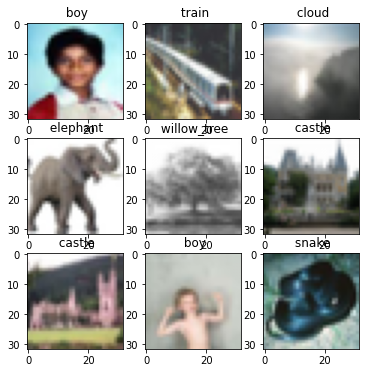

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

**Some important comments:**

**Dense layer**: Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer. 

**Convoluational Neural Network** : A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. 

**Max Pooling** : The Pooling layer is responsible for reducing the spatial size of the Convolved Feature. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features which are rotational and positional invariant, thus maintaining the process of effectively training of the model. Max Pooling returns the maximum value from the portion of the image covered by the Kernel.

**Flatten** : Flatten is the function that converts the pooled feature map to a single column that is passed to the fully connected layer. Dense adds the fully connected layer to the neural network

**Learning rate** : Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0. The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs. A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck. The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.

**Activation functions**:
*   *Relu* : The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
*   *Softmax* : The softmax function is a generalization of the logistic function to multiple dimensions. It is used in multinomial logistic regression and is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes.

**Dropout**: Dropout is an approach to regularization in neural networks which helps reducing interdependent learning amongst the neurons.


**Description of the model:**

* 1st layer: Convoluational, 32 filters and output shape 30 x 30 x 32, total parameters 896, activation function: ReLU
* 2nd layer: MaxPoolig layer, output shape 15 x 15 x 32, total paremeters 0
* 3rd layer: Convoluational Layer, 64 filters and output shape 13 x 13 x 64, total parameters 18496, activation function: ReLU
* 4rth layer: MaxPoolig layer, output shape 6 x 6 x 64, total paremeters 0
* 6th layer: Convoluational Layer, 128 filters and output shape 4 x 4 x 128, total parameters 73856, activation function: ReLU
* 7th layer: Flatten layer, output shape 1 x 2048, total paremeters 0
* 8th layer: Dense layer, 64 layers and output shape 1 x 64, total paremeters 131136, activation function: ReLU
* 9th layer: Dense layer, 100 layers and output shape 1 x 100, total paremeters 6500, activation function: softmax

**TOTAL TRAINABLE PARAMETERS = 230.884**

In [ ]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
# early stopping and model checkpoint
callbacks_cifar_20_simple = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight_simple.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds =_input_fn(x_train,y_train, BATCH_SIZE,False) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE,False) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE,False) #PrefetchDataset object

After many tries we came to a conclusion that batch size 256 is the best for this model.

In [ ]:
import time
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history , time = train_model(SIMPLE_MODEL,callbacks_cifar_20_simple, 150, 30, 5)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [ ]:
early_model_cifar20 = load_model('/content/gdrive/My Drive/best_weight_simple.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',time)

Ο χρόνος εκτέλεσης: 73.49756240844727


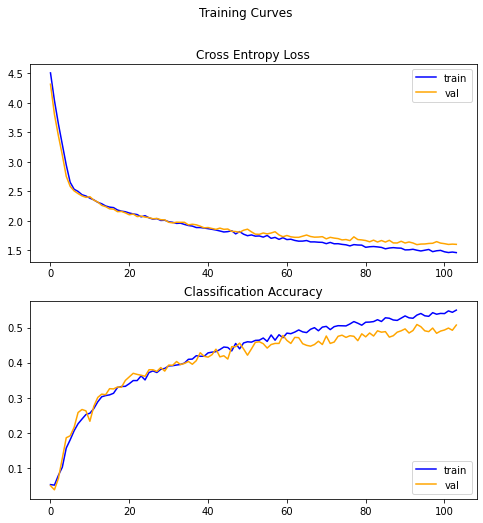


Test set evaluation metrics
7/7 [==============================] - 0s 10ms/step - loss: 1.6680 - accuracy: 0.4888
loss: 1.67
accuracy: 0.49


In [ ]:
model_report(SIMPLE_MODEL,SIMPLE_MODEL_history,len(y_test)//BATCH_SIZE)

We tried the basic from scratch model and we achieved a score of 49%. We were able to achieve this score with early stopping and change in batch size-epochs.

# **Fine tuning**

After running the model that was given to us, we decided to build our own model from scratch. We notice that the accuracy metrics are improved so all the processes from now on will be done with our model

## **CIFAR-20(V1)**

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number()

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

[' bed', ' boy', ' can', ' castle', ' chair', ' cloud', ' crocodile', ' elephant', ' house', ' lizard', ' otter', ' palm_tree', ' pear', ' rocket', ' shark', ' snake', ' sweet_pepper', ' train', ' tulip', ' willow_tree']


In [ ]:
CLASSES_NUM=len(our_classes)
print(CLASSES_NUM)

20


1500
Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


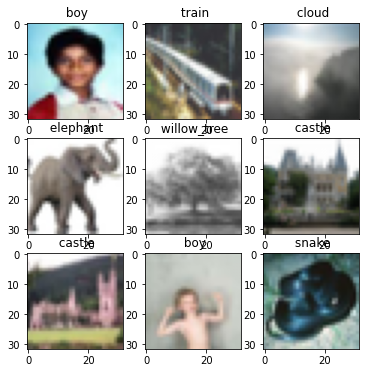

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

**Description of the model:**

* 1st layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 896, activation function: ReLU
* 2nd layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 9248, activation function: ReLU
* 3rd layer: MaxPoolig layer, output shape 16 x 16 x 32, total paremeters 0
* 4th layer: Convoluational Layer, 64 filters and output shape 16 x 16 x 64, total parameters 18496, activation function: ReLU
* 5th layer: Convoluational, 64 filters and output shape 16 x 16 x 64, total parameters 36928, activation function: ReLU
* 6th layer: MaxPoolig layer, output shape 8 x 8 x 64, total paremeters 0
* 7th layer: Convoluational, 128 filters and output shape 8 x 8 x 128, total parameters 73856, activation function: ReLU
* 8th layer: MaxPoolig layer, output shape 4 x 4 x 128, total paremeters 0
* 9th layer: Convoluational Layer, 128 filters and output shape 4 x 4 x 128, total parameters 73856, activation function: ReLU
* 10th layer: MaxPoolig layer, output shape 4 x 4 x 128, total parameters 0
* 11th layer: Dropout layer, dropout rate:0.5 output shape 4 x 4 x 128, total parameters 0
* 12th layer: Dense layer, 128 layers and output shape 1 x 128, total paremeters 262272, activation function: ReLU
* 13th layer: Dense layer, 100 layers and output shape 1 x 100, total paremeters 12900, activation function: softmax

**TOTAL TRAINABLE PARAMETERS = 414.596**

In [ ]:
def cifar_20_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
   model.summary()
  return model

###**CIFAR-20(V1) without data_augmentation**

**Early Stopping**: Stop training when a monitored metric has stopped improving.

In [ ]:
# early stopping and model checkpoint
callbacks_cifar_20 = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight01.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,False) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object
# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time

cifar_20 = cifar_20_model(summary = True)
cifar_20_history , cifar20_time = train_model(cifar_20,callbacks_cifar_20, 100, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of train set for steps per epoch value

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
early_model_cifar20 = load_model('/content/gdrive/My Drive/best_weight01.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar20_time)

Ο χρόνος εκτέλεσης: 28.21674633026123


From the above, we see that our model manages to reach an approximate accuracy of 60% in 45 sec. A detailed report is provided below:



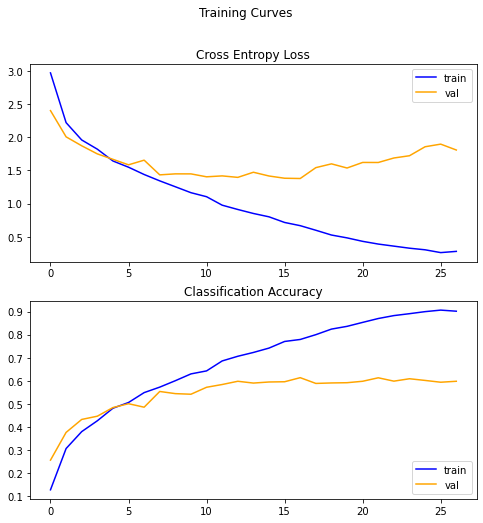


Test set evaluation metrics
15/15 [==============================] - 0s 5ms/step - loss: 1.4361 - accuracy: 0.5984
loss: 1.44
accuracy: 0.60


In [ ]:
model_report(early_model_cifar20,cifar_20_history,len(y_test)//BATCH_SIZE)

### **CIFAR-20(V1) with data_augmentation** 

In [ ]:
# early stopping and model checkpoint
callbacks_cifar_20_aug = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight02.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,True) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object
# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 200
  * Early Stopping Patience: 10

In [ ]:
import time

cifar_20_aug = cifar_20_model(summary = True)
cifar_20_history_aug , cifar20_aug_time = train_model(cifar_20_aug,callbacks_cifar_20_aug, 200, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of train set for steps per epoch value

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
early_model_cifar20_aug = load_model('/content/gdrive/My Drive/best_weight02.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar20_aug_time)

Ο χρόνος εκτέλεσης: 119.93313026428223


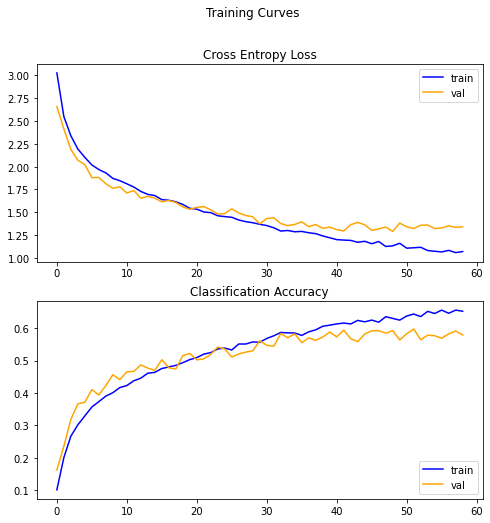


Test set evaluation metrics
15/15 [==============================] - 0s 6ms/step - loss: 1.3604 - accuracy: 0.5755
loss: 1.36
accuracy: 0.58


In [ ]:
model_report(early_model_cifar20_aug,cifar_20_history_aug,len(y_test)//BATCH_SIZE)

The difference between the two model is that with data augmentation the model has a more smooth training procedure(training accuracy with validation accuracy are close enough).

## **CIFAR-40(V1)**

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number(40)

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

['apple', ' baby', ' bed', ' bee', ' beetle', ' bicycle', ' bowl', ' butterfly', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' couch', ' cup', ' dolphin', ' hamster', ' house', ' kangaroo', ' lawn_mower', ' leopard', ' maple_tree', ' mouse', ' oak_tree', ' orange', ' otter', ' palm_tree', ' plate', ' rabbit', ' rocket', ' seal', ' spider', ' sunflower', ' table', ' tiger', ' train', ' trout', ' turtle', ' whale']


In [ ]:
CLASSES_NUM=len(our_classes)
print(CLASSES_NUM)

40


3000
Train: X=(17000, 32, 32, 3), y=(17000, 1)
Validation: X=(3000, 32, 32, 3), y=(3000, 1)
Test: X=(4000, 32, 32, 3), y=(4000, 1)


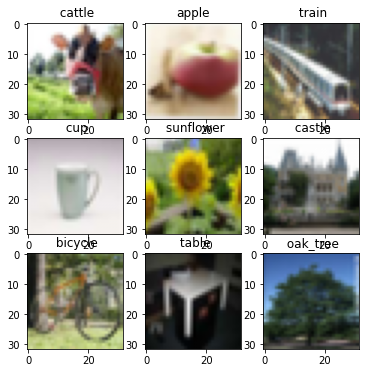

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

**Description of the model:**

* 1st layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 896, activation function: ReLU
* 2nd layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 9248, activation function: ReLU
* 3rd layer: MaxPoolig layer, output shape 16 x 16 x 32, total paremeters 0
* 4th layer: Convoluational Layer, 64 filters and output shape 16 x 16 x 64, total parameters 18496, activation function: ReLU
* 5th layer: Convoluational, 64 filters and output shape 16 x 16 x 64, total parameters 36928, activation function: ReLU
* 6th layer: MaxPoolig layer, output shape 8 x 8 x 64, total paremeters 0
* 7th layer: Convoluational, 128 filters and output shape 8 x 8 x 128, total parameters 73856, activation function: ReLU
* 8th layer: MaxPoolig layer, output shape 4 x 4 x 128, total paremeters 0
* 9th layer: Convoluational Layer, 128 filters and output shape 4 x 4 x 128, total parameters 73856, activation function: ReLU
* 10th layer: MaxPoolig layer, output shape 4 x 4 x 128, total parameters 0
* 11th layer: Dropout layer, dropout rate:0.5 output shape 4 x 4 x 128, total parameters 0
* 12th layer: Dense layer, 128 layers and output shape 1 x 128, total paremeters 262272, activation function: ReLU
* 13th layer: Dense layer, 100 layers and output shape 1 x 100, total paremeters 12900, activation function: softmax

**TOTAL TRAINABLE PARAMETERS = 414.596**

In [ ]:
def cifar_40_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
   model.summary()
  return model

### **CIFAR-40(V1) without data_augmentation**

In [ ]:
# early stopping and model checkpoint
callbacks_cifar_40 = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight03.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds =_input_fn(x_train,y_train, BATCH_SIZE,False) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE,False) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE,False) #PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time
cifar_40 = cifar_40_model(summary = True)
cifar_40_history , cifar40_time = train_model(cifar_40,callbacks_cifar_40, 100, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of train set for steps per epoch value

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
early_model_cifar40 = load_model('/content/gdrive/My Drive/best_weight03.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar40_time)

Ο χρόνος εκτέλεσης: 48.71377110481262


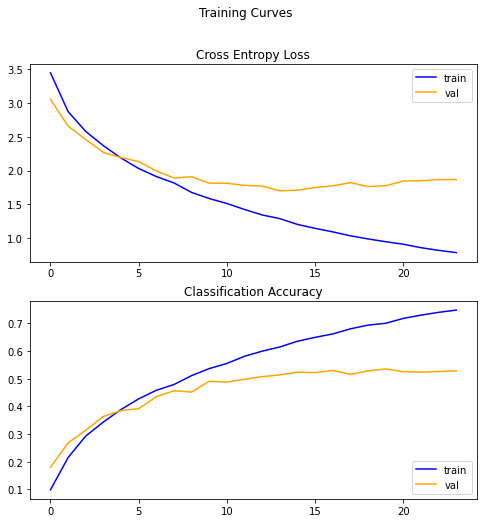


Test set evaluation metrics
31/31 [==============================] - 0s 6ms/step - loss: 1.7968 - accuracy: 0.5403
loss: 1.80
accuracy: 0.54


In [ ]:
model_report(cifar_40,cifar_40_history,len(y_test)//BATCH_SIZE)

### **CIFAR-40(V1) with data_augmentation**

In [ ]:
# early stopping and model checkpoint
callbacks_cifar_40_aug = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight04.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,True) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 200
  * Early Stopping Patience: 10

In [ ]:
import time

cifar_40_aug = cifar_40_model(summary = True)
cifar_40_history_aug , cifar40_aug_time = train_model(cifar_40_aug,callbacks_cifar_40_aug, 200, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of validation set for steps per epoch value

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
early_model_cifar40_aug = load_model('/content/gdrive/My Drive/best_weight04.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar40_aug_time)

Ο χρόνος εκτέλεσης: 205.19916605949402


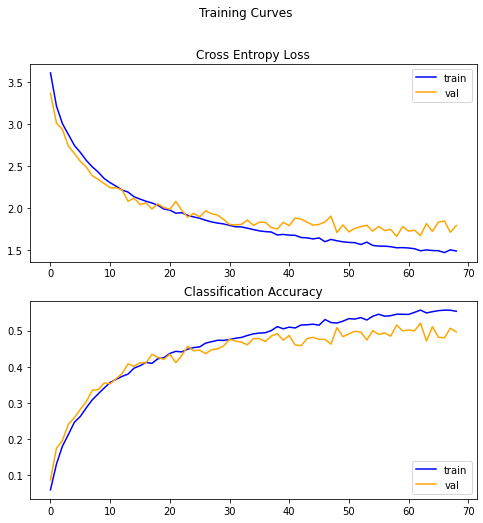


Test set evaluation metrics
31/31 [==============================] - 0s 6ms/step - loss: 1.6241 - accuracy: 0.5287
loss: 1.62
accuracy: 0.53


In [ ]:
model_report(early_model_cifar40_aug,cifar_40_history_aug,len(y_test)//BATCH_SIZE)

In this case also, the difference between the two model is that with data augmentation the model has a more smooth training procedure(training accuracy with validation accuracy are close enough).

## **CIFAR-60(V1)**

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number(60)

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

[' aquarium_fish', ' baby', ' beaver', ' bed', ' beetle', ' bicycle', ' bowl', ' boy', ' bridge', ' butterfly', ' can', ' castle', ' caterpillar', ' clock', ' cloud', ' couch', ' crab', ' crocodile', ' cup', ' dolphin', ' elephant', ' flatfish', ' forest', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' man', ' maple_tree', ' motorcycle', ' mountain', ' oak_tree', ' otter', ' palm_tree', ' pear', ' pine_tree', ' plain', ' plate', ' poppy', ' rabbit', ' road', ' seal', ' shark', ' shrew', ' skunk', ' skyscraper', ' snake', ' spider', ' squirrel', ' sunflower', ' sweet_pepper', ' television', ' train', ' whale', ' willow_tree', ' wolf', ' woman', ' worm']


In [ ]:
CLASSES_NUM=len(our_classes)
print(CLASSES_NUM)

60


4500
Train: X=(25500, 32, 32, 3), y=(25500, 1)
Validation: X=(4500, 32, 32, 3), y=(4500, 1)
Test: X=(6000, 32, 32, 3), y=(6000, 1)


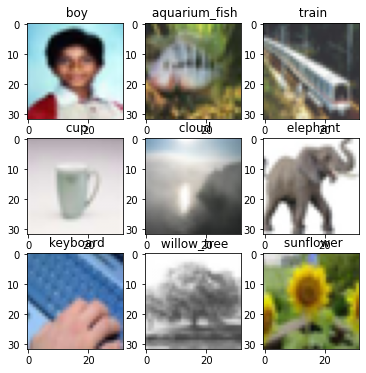

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

**Description of the model:**

* 1st layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 896, activation function: ReLU
* 2nd layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 9248, activation function: ReLU
* 3rd layer: MaxPoolig layer, output shape 16 x 16 x 32, total paremeters 0
* 4th layer: Convoluational Layer, 64 filters and output shape 16 x 16 x 64, total parameters 18496, activation function: ReLU
* 5th layer: Convoluational, 64 filters and output shape 16 x 16 x 64, total parameters 36928, activation function: ReLU
* 6th layer: MaxPoolig layer, output shape 8 x 8 x 64, total paremeters 0
* 7th layer: Convoluational, 128 filters and output shape 8 x 8 x 128, total parameters 73856, activation function: ReLU
* 8th layer: MaxPoolig layer, output shape 4 x 4 x 128, total paremeters 0
* 9th layer: Convoluational Layer, 128 filters and output shape 4 x 4 x 128, total parameters 73856, activation function: ReLU
* 10th layer: MaxPoolig layer, output shape 4 x 4 x 128, total parameters 0
* 11th layer: Dropout layer, dropout rate:0.5 output shape 4 x 4 x 128, total parameters 0
* 12th layer: Dense layer, 128 layers and output shape 1 x 128, total paremeters 262272, activation function: ReLU
* 13th layer: Dense layer, 100 layers and output shape 1 x 100, total paremeters 12900, activation function: softmax

**TOTAL TRAINABLE PARAMETERS = 414.596**

In [ ]:
def cifar_60_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
   model.summary()
  return model

### **CIFAR-60(V1) without data_augmentation**

In [ ]:
callbacks_cifar_60 = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight05.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,False) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time
cifar_60 = cifar_60_model(summary = True)
cifar_60_history , cifar60_time = train_model(cifar_60,callbacks_cifar_60, 100,len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of validation set for steps per epoch value

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
early_model_cifar60 = load_model('/content/gdrive/My Drive/best_weight05.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar60_time)

Ο χρόνος εκτέλεσης: 66.81377696990967


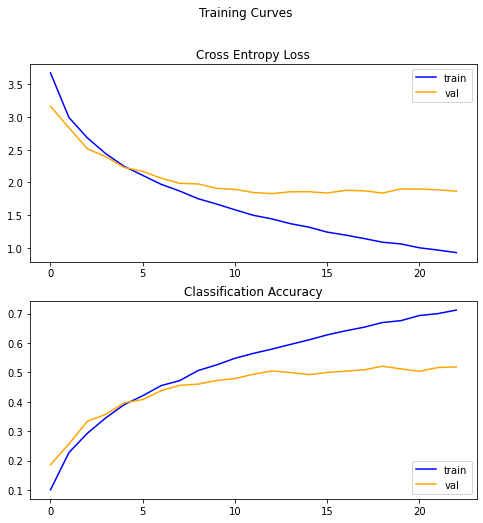


Test set evaluation metrics
46/46 [==============================] - 1s 5ms/step - loss: 1.8164 - accuracy: 0.5088
loss: 1.82
accuracy: 0.51


In [ ]:
model_report(early_model_cifar60,cifar_60_history,len(y_test)//BATCH_SIZE)

### **CIFAR-60(V1) with data_augmentation**

In [ ]:
callbacks_cifar_60_aug = [EarlyStopping(monitor='val_loss', patience = 30),ModelCheckpoint('/content/gdrive/My Drive/best_weight06.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,True) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 200
  * Early Stopping Patience: 30

In [ ]:
import time
cifar_60_aug = cifar_60_model(summary = True)
cifar_60_history_aug , cifar60_aug_time = train_model(cifar_60_aug,callbacks_cifar_60_aug, 200,len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of validation set for steps per epoch value

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
early_model_cifar60_aug = load_model('/content/gdrive/My Drive/best_weight06.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar60_time)

Ο χρόνος εκτέλεσης: 66.81377696990967


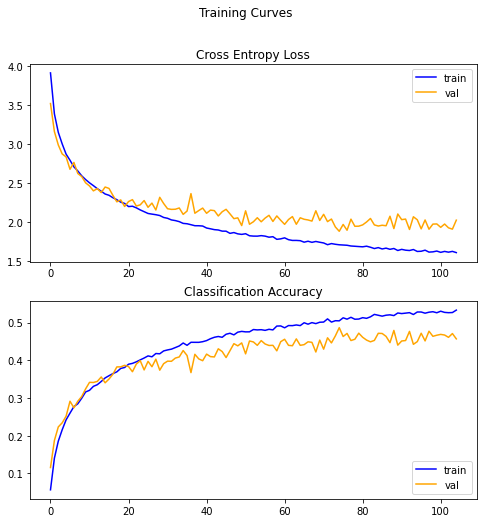


Test set evaluation metrics
46/46 [==============================] - 1s 6ms/step - loss: 1.8451 - accuracy: 0.4839
loss: 1.85
accuracy: 0.48


In [ ]:
model_report(early_model_cifar60_aug,cifar_60_history_aug,len(y_test)//BATCH_SIZE)

The difference between the two model is that with data augmentation the model has a more smooth training procedure(training accuracy with validation accuracy are close enough).

## **CIFAR-80(V1-TRANSFER LEARNING)**

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number(80)

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

['apple', ' aquarium_fish', ' baby', ' bear', ' beaver', ' bed', ' bee', ' beetle', ' bicycle', ' bottle', ' bowl', ' boy', ' bridge', ' bus', ' camel', ' can', ' caterpillar', ' cattle', ' chair', ' cloud', ' cockroach', ' couch', ' crab', ' crocodile', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' hamster', ' house', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' mouse', ' mushroom', ' oak_tree', ' orange', ' orchid', ' otter', ' pear', ' pine_tree', ' plain', ' plate', ' poppy', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rose', ' sea', ' seal', ' shrew', ' snake', ' spider', ' squirrel', ' sunflower', ' sweet_pepper', ' table', ' tank', ' telephone', ' television', ' tiger', ' tractor', ' train', ' trout', ' tulip', ' turtle', ' whale', ' woman', ' worm']


In [ ]:
CLASSES_NUM=len(our_classes)
print(CLASSES_NUM)

80


6000
Train: X=(34000, 32, 32, 3), y=(34000, 1)
Validation: X=(6000, 32, 32, 3), y=(6000, 1)
Test: X=(8000, 32, 32, 3), y=(8000, 1)


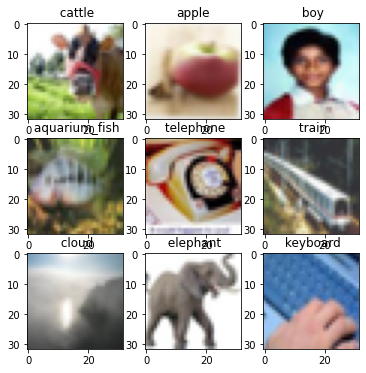

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

**Description of the model:**

* 1st layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 896, activation function: ReLU
* 2nd layer: Convoluational, 32 filters and output shape 32 x 32 x 32, total parameters 9248, activation function: ReLU
* 3rd layer: MaxPoolig layer, output shape 16 x 16 x 32, total paremeters 0
* 4th layer: Convoluational Layer, 64 filters and output shape 16 x 16 x 64, total parameters 18496, activation function: ReLU
* 5th layer: Convoluational, 64 filters and output shape 16 x 16 x 64, total parameters 36928, activation function: ReLU
* 6th layer: MaxPoolig layer, output shape 8 x 8 x 64, total paremeters 0
* 7th layer: Convoluational, 128 filters and output shape 8 x 8 x 128, total parameters 73856, activation function: ReLU
* 8th layer: MaxPoolig layer, output shape 4 x 4 x 128, total paremeters 0
* 9th layer: Convoluational Layer, 128 filters and output shape 4 x 4 x 128, total parameters 73856, activation function: ReLU
* 10th layer: MaxPoolig layer, output shape 4 x 4 x 128, total parameters 0
* 11th layer: Dropout layer, dropout rate:0.5 output shape 4 x 4 x 128, total parameters 0
* 12th layer: Dense layer, 128 layers and output shape 1 x 128, total paremeters 262272, activation function: ReLU
* 13th layer: Dense layer, 100 layers and output shape 1 x 100, total paremeters 12900, activation function: softmax

**TOTAL TRAINABLE PARAMETERS = 414.596**

In [ ]:
def cifar_80_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
   model.summary()
  return model

###**CIFAR-80 without data_augmentation**

In [ ]:
callbacks_cifar_80 = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight07.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,False) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time
cifar_80 = cifar_80_model(summary = True)
cifar_80_history , cifar80_time = train_model(cifar_80,callbacks_cifar_80, 100, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of validation set for steps per epoch value

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 8, 8, 128)       

In this case, early stopping function had been triggered, because our model was nearly stable for ten in a row epochs.

In [ ]:
early_model_cifar80 = load_model('/content/gdrive/My Drive/best_weight07.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar80_time)

Ο χρόνος εκτέλεσης: 112.57406806945801


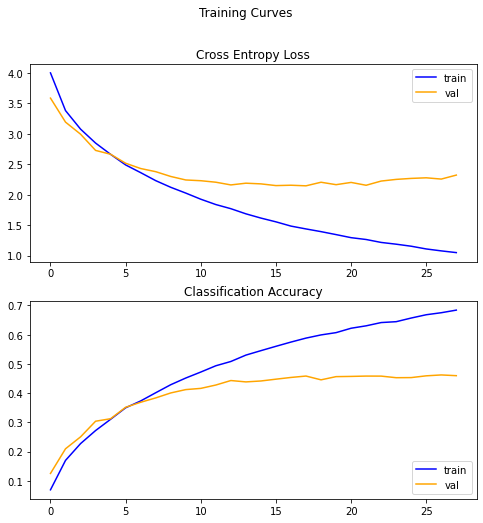


Test set evaluation metrics
62/62 [==============================] - 1s 6ms/step - loss: 2.1125 - accuracy: 0.4632
loss: 2.11
accuracy: 0.46


In [ ]:
model_report(early_model_cifar80,cifar_80_history,len(y_test)//BATCH_SIZE)

### **CIFAR-80 with data_augmentation**

In [ ]:
callbacks_cifar_80_aug = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight08.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,True) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time
cifar_80_aug = cifar_80_model(summary = True)
cifar_80_history_aug , cifar80_aug_time = train_model(cifar_80_aug,callbacks_cifar_80_aug, 200, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of validation set for steps per epoch value

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
early_model_cifar80_aug = load_model('/content/gdrive/My Drive/best_weight08.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar80_aug_time)

Ο χρόνος εκτέλεσης: 331.9079587459564


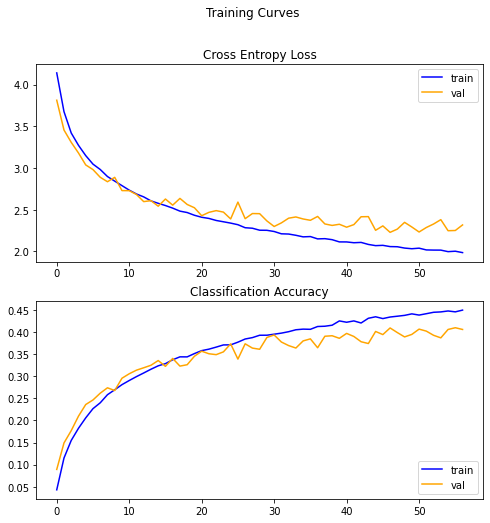


Test set evaluation metrics
62/62 [==============================] - 1s 6ms/step - loss: 2.2065 - accuracy: 0.4181
loss: 2.21
accuracy: 0.42


In [ ]:
model_report(early_model_cifar80_aug,cifar_80_history_aug,len(y_test)//BATCH_SIZE)

In this case, data augmentation, caused the reduction of the test accuracy and augmentation of test loss.

### **Results in CIFAR-80 with Transfer Learning: VGG16**

Let’s go over the architecture of VGG:

* **Input**: VGG takes in a 224x224 pixel RGB image. For the ImageNet competition, the authors cropped out the center 224x224 patch in each image to keep the input image size consistent.
* **Convolutional Layers**: The convolutional layers in VGG use a very small receptive field (3x3, the smallest possible size that still captures left/right and up/down). There are also 1x1 convolution filters which act as a linear transformation of the input, which is followed by a ReLU unit. The convolution stride is fixed to 1 pixel so that the spatial resolution is preserved after convolution.
* **Fully-Connected Layers**: VGG has three fully-connected layers: the first two have 4096 channels each and the third has 1000 channels, 1 for each class.
* **Hidden Layers**: All of VGG’s hidden layers use ReLU (a huge innovation from AlexNet that cut training time). VGG does not generally use Local Response Normalization (LRN), as LRN increases memory consumption and training time with no particular increase in accuracy.

**Description of the model:**

* 1st Layer: 2 x Convolution layer of 64 channel of 3x3 kernal and same padding
* 2nd Layer: 1 x Maxpool layer of 2x2 pool size and stride 2x2
* 3rd Layers: 2 x Convolution layer of 128 channel of 3x3 kernal and same padding
* 4th Layer: 1 x Maxpool layer of 2x2 pool size and stride 2x2
* 5th Layer: 3 x Convolution layer of 256 channel of 3x3 kernal and same padding
* 6th Layer: 1 x Maxpool layer of 2x2 pool size and stride 2x2
* 7th Layer: 3 x Convolution layer of 512 channel of 3x3 kernal and same padding
* 8th Layer: 1 x Maxpool layer of 2x2 pool size and stride 2x2
* 9th Layer: 3 x Convolution layer of 512 channel of 3x3 kernal and same padding
* 10th Layer: 1 x Maxpool layer of 2x2 pool size and stride 2x2

I also add relu(Rectified Linear Unit) activation to each layers so that all the negative values are not passed to the next layer.

* 11th Layer: 1 x Dense layer of 4096 units
* 12th Layer: 1 x Dense layer of 1024 units
* 13th Layer: 1 x Dense Layer of 500 units
* 14th Layer: 1 x Dense Layer of 500 units with softmax activation
* 15th Layer: 1 x Dense Layer of 500 units with softmax activation

**TOTAL TRAINABLE PARAMETERS(due to transfer learning) = 51,300**

In [ ]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  # unfreeze conv layers
  VGG16_MODEL.trainable = False

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

#### **VGG16 without data_augmentation**

In [ ]:
callbacks_vgg16 = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight10.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds =_input_fn(x_train,y_train, BATCH_SIZE,False) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE,False) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE,False) #PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time
VGG16_MODEL = init_VGG16_model(summary = True)
VGG16_MODEL_history ,VGG16_time = train_model(VGG16_MODEL,callbacks_vgg16, 100, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               51300     
Total params: 14,765,988
Trainable params: 51,300
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
265/265 [==============================] - 8s 24ms/step - loss: 3.7523 - accuracy: 0.1324 - val_loss: 2.8811 - val_accuracy: 0.2839
Epoch 2/100
265/265 [====

In [ ]:
early_model_VGG16 = load_model('/content/gdrive/My Drive/best_weight10.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',VGG16_time)

Ο χρόνος εκτέλεσης: 131.10755825042725


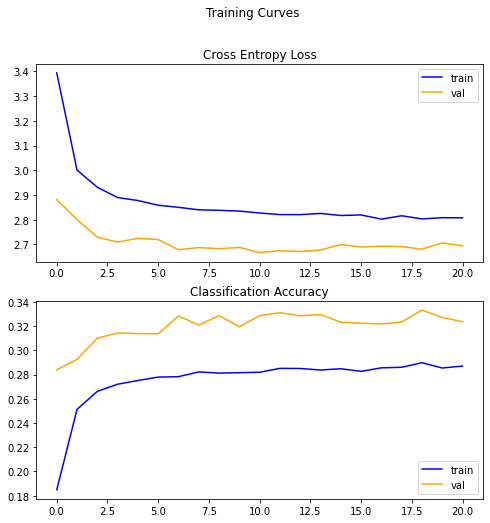


Test set evaluation metrics
62/62 [==============================] - 1s 18ms/step - loss: 2.6496 - accuracy: 0.3400
loss: 2.65
accuracy: 0.34


In [ ]:
model_report(early_model_VGG16,VGG16_MODEL_history,len(y_test)//BATCH_SIZE)

#### **VGG16 with data_augmentation**

In [ ]:
callbacks_vgg16_aug = [EarlyStopping(monitor='val_loss', patience = 10),ModelCheckpoint('/content/gdrive/My Drive/best_weight11.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds =_input_fn(x_train,y_train, BATCH_SIZE,True) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE,False) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE,False) #PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.001
  * Epochs: 100
  * Early Stopping Patience: 10

In [ ]:
import time
VGG16_MODEL_aug = init_VGG16_model(summary = True)
VGG16_MODEL_history_aug ,VGG16_aug_time = train_model(VGG16_MODEL_aug,callbacks_vgg16_aug, 100, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               51300     
Total params: 14,765,988
Trainable params: 51,300
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
265/265 [==============================] - 8s 28ms/step - loss: 3.9139 - accuracy: 0.1044 - val_loss: 3.1205 - val_accuracy: 0.2308
Epoch 2/100
265/265 [==============================] - 7s 28ms/step - loss: 3.3330 - accur

In [ ]:
early_model_VGG16_aug = load_model('/content/gdrive/My Drive/best_weight11.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',VGG16_aug_time)

Ο χρόνος εκτέλεσης: 175.02968406677246


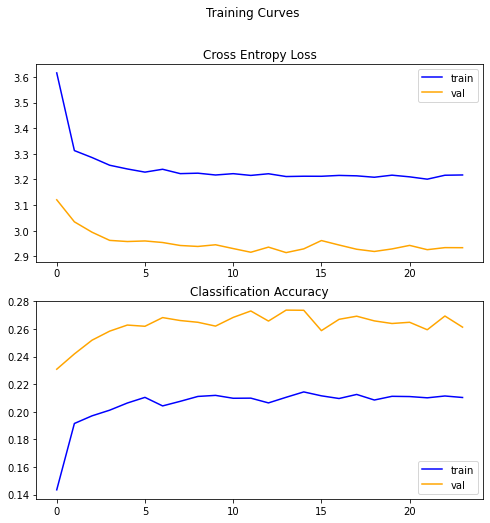


Test set evaluation metrics
62/62 [==============================] - 2s 18ms/step - loss: 2.9045 - accuracy: 0.2743
loss: 2.90
accuracy: 0.27


In [ ]:
model_report(early_model_VGG16_aug,VGG16_MODEL_history_aug,len(y_test)//BATCH_SIZE)

### **Results in CIFAR-80 with Transfer Learning: ResNet50**

**Description of the model:**

The architecture of ResNet50 has 3 Layers and then, 4 stages.

* 1st Layer: 7x7 Convolution, with 64 filters and stride 2
* 2nd Layer: 3x3 Max Pooling, with stride 2
* Stage 1: It has 3 Residual blocks(all of them identity blocks) containing 3 layers each. The size of kernels used to perform the convolution operation in all 3 layers of the block are 64, 64 and 128 respectively.The three layers are 1×1, 3×3, 1×1 convolutions. Every block 
* Stage 2: It has 4 Residual blocks(first one convolutional block, all the other identity blocks) containing 3 layers each. The size of kernels used to perform the convolution operation in all 3 layers of the block of stage 1 are 128, 128 and 521 respectively.The three layers are 1×1, 3×3, 1×1 convolutions.
* Stage 3: It has 6 Residual blocks(first one convolutional block, all the other identity blocks) containing 3 layers each. The size of kernels used to perform the convolution operation in all 3 layers of the block of stage 1 are 256, 256 and 1024 respectively.The three layers are 1×1, 3×3, 1×1 convolutions.
* Stage 4: It has 3 Residual blocks(first one convolutional block, all the other identity blocks) containing 3 layers each. The size of kernels used to perform the convolution operation in all 3 layers of the block of stage 1 are 512, 512 and 2048 respectively.The three layers are 1×1, 3×3, 1×1 convolutions.
* Next to last Layer: Average Pooling
* Last Layer: Fully Connected 1000


The 1×1 convolution layers are responsible for reducing and then restoring the dimensions. The 3×3 layer is left as a bottleneck with smaller input/output dimensions.

Finally, the network has an Average Pooling layer followed by a fully connected layer having 1000 neurons.
  
**TOTAL TRAINABLE PARAMETERS = 23,792,612**

In [ ]:
# transfer learning: ResNet50 trained on ImageNet without the top layer

def init_ResNet50_model(summary,learning_rate):
  resnet_model=tf.keras.applications.ResNet50(input_shape=(32,32,3), include_top=False, weights='imagenet')

  RESNET50_MODEL=resnet_model.layers[0](resnet_model)

  # unfreeze conv layers
  RESNET50_MODEL.trainable = True # we are going to train all layers from the beginning,without our results were bad

  dropout_layer = tf.keras.layers.Dropout(rate = 0.25)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([RESNET50_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

#### **Resnet50 without data_augmentation**

In [ ]:
callbacks_resnet= [EarlyStopping(monitor='val_loss', patience = 5),ModelCheckpoint('/content/gdrive/My Drive/best_weight12.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds =_input_fn(x_train,y_train, BATCH_SIZE,False) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE,False) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE,False) #PrefetchDataset object

After several tries we ended up with:
  * Batch size: 64
  * Learning rate: 0.0001( with bigger value was overfitting very fast)
  * Epochs: 6 (limit for overfitting problems)
  * Early Stopping Patience: 5 


In [ ]:
import time

RESNET50_MODEL = init_ResNet50_model(True,0.0001)
RESNET50_MODEL_history , resnet_time = train_model(RESNET50_MODEL,callbacks_resnet, 6, len(y_train)//BATCH_SIZE, len(x_val)//BATCH_SIZE) # we used the length of train set for steps per epoch value

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               204900    
Total params: 23,792,612
Trainable params: 23,739,492
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/6
531/531 [==============================] - 34s 52ms/step - loss: 4.7754 - accuracy: 0.0876 - val_loss: 13.2711 - val_accuracy: 0.0121
Epoch 2/6
531/531 [======

In [ ]:
early_model_ResNet = load_model('/content/gdrive/My Drive/best_weight12.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',resnet_time)

Ο χρόνος εκτέλεσης: 174.96003341674805


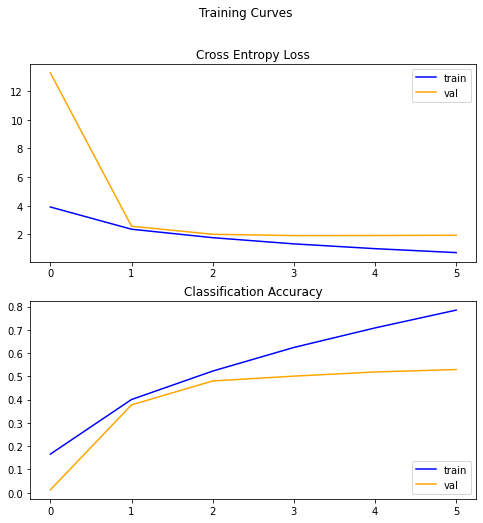


Test set evaluation metrics
125/125 [==============================] - 3s 15ms/step - loss: 1.8818 - accuracy: 0.5088
loss: 1.88
accuracy: 0.51


In [ ]:
model_report(early_model_ResNet,RESNET50_MODEL_history,len(y_test)//BATCH_SIZE)

In conclusion, we see that our model achieved 50% accuracy. Also, we can easily undestand that with more epochs our model will end up overfitting, so we tried to avoid that.

#### **Resnet50 with data_augmentation**

In [ ]:
callbacks_resnet_aug= [EarlyStopping(monitor='val_loss', patience = 5),ModelCheckpoint('/content/gdrive/My Drive/best_weight13.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds =_input_fn(x_train,y_train, BATCH_SIZE,False) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE,False) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE,False) #PrefetchDataset object

We will try to achieve something better with data augmentation on our model ResNet50.

After several tries we ended up with:
  * Batch size: 64
  * Learning rate: 0.0001( with bigger value was overfitting very fast)
  * Epochs: 6 (limit for overfitting problems)
  * Early Stopping Patience: 5 

In [ ]:
import time
ResNet_MODEL_aug = init_ResNet50_model(True,0.0001)
ResNet_MODEL_history_aug , resnet_aug_time = train_model(ResNet_MODEL_aug,callbacks_resnet_aug, 6, len(y_train)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of train set for steps per epoch value

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               204900    
Total params: 23,792,612
Trainable params: 23,739,492
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/6
531/531 [==============================] - 34s 54ms/step - loss: 4.7809 - accuracy: 0.0853 - val_loss: 12.5709 - val_accuracy: 0.0160
Epoch 2/6
531/531 [==============================] - 28s 53ms/step - loss: 2.5228 - accura

In [ ]:
early_model_ResNet_aug= load_model('/content/gdrive/My Drive/best_weight13.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',resnet_aug_time)

Ο χρόνος εκτέλεσης: 180.16776490211487


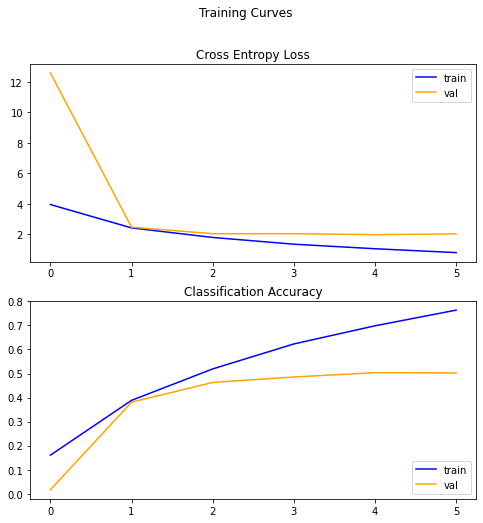


Test set evaluation metrics
125/125 [==============================] - 3s 15ms/step - loss: 1.9931 - accuracy: 0.5077
loss: 1.99
accuracy: 0.51


In [ ]:
model_report(early_model_ResNet_aug,ResNet_MODEL_history_aug,len(y_test)//BATCH_SIZE)

The above report showed that data augmentation didn't help our model to achieve something better, although we could optimize our batch size,epochs,learning rate to help the model rise. 

A general conclusion worth mentioning is that in the selected models for Cifar80 we notice that in transfer learning many more parameters were used than in the from scratch model and the accuracy in the second one was better. Specifically, for the ResNet50 the total number of parameters was about 23 million and for the VGG16 it was 15 million. On the contrary, for the from scratch model about 709 thousand parameters were used.


## **From Scratch-Better Version(V2)**

**Description of the model:**

* 1st layer: Convoluational, 64 filters, activation ReLu and same padding
* 2nd layer: Convoluational, 64 filters, activation ReLu and same padding
* 3rd layer: Batch Normalization, 0.8 momentum
* 4th layer: MaxPoolig2D with 2x2 kernel
* 5th layer: Convoluational, 128 filters, activation ReLu and same padding
* 6th layer: Convoluational, 128 filters, activation ReLu and same padding
* 7th layer: Batch Normalization, 0.8 momentum
* 8th layer: MaxPoolig2D with 2x2 kernel
* 9th layer: Convoluational, 256 filters, activation ReLu and same padding
* 10th layer: Convoluational, 256 filters, activation ReLu and same padding
* 11th layer: Batch Normalization, 0.8 momentum
* 12th layer: MaxPoolig2D with 2x2 kernel
* 13th layer: Dropout layer with 0.3 dropout rate
* 14th layer: Dense layer 1024 units, activation ReLu and uniform kernel initializer
* 15th layer: Dropout layer with 0.3 dropout rate
* 16th layer:  Dense layer 512 units, activation ReLu and uniform kernel initializer
* 17th layer: Dropout layer with 0.3 dropout rate
* 18th layer:  Dense layer 128 units, activation ReLu and uniform kernel initializer
* 19th layer:  Dense layer 100 units, activation softmax

**TOTAL TRAINABLE PARAMETERS = 5,944,996**

Below we can see the model.In this model we will use data augmentation.

In [ ]:
def cifar_80_model_b(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu',kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
   model.summary()
  return model

In [ ]:
callbacks_cifar_80_b = [EarlyStopping(monitor='val_loss', patience = 30),ModelCheckpoint('/content/gdrive/My Drive/best_weight09.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

train_ds = _input_fn(x_train,y_train, BATCH_SIZE,True) # PrefetchDataset object
validation_ds = _input_fn(x_val,y_val, BATCH_SIZE,False) # PrefetchDataset object
test_ds = _input_fn(x_test,y_test, BATCH_SIZE,False) # PrefetchDataset object

After several tries we ended up with:
  * Batch size: 128
  * Learning rate: 0.0005
  * Epochs: 300
  * Early Stopping Patience: 30

In [ ]:
import time
cifar_80_b = cifar_80_model_b(summary = True)
cifar_80_history_b , cifar80_b_time = train_model(cifar_80_b,callbacks_cifar_80_b, 300, len(y_val)//BATCH_SIZE, len(y_test)//BATCH_SIZE) # we used the length of validation set for steps per epoch value

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_269 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 128)     

In [ ]:
early_model_cifar80_b = load_model('/content/gdrive/My Drive/best_weight09.h5')

In [ ]:
print('Ο χρόνος εκτέλεσης:',cifar80_b_time)

Ο χρόνος εκτέλεσης: 1377.783252954483


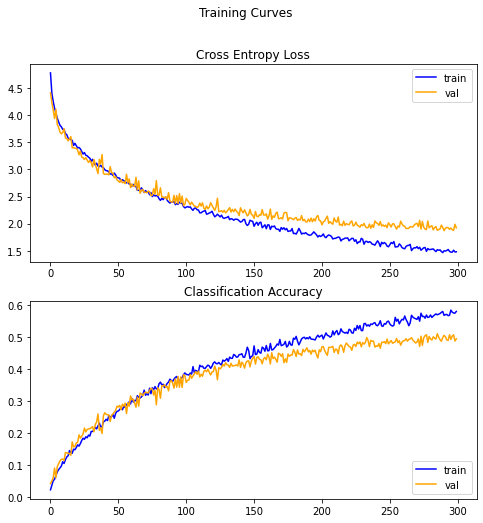


Test set evaluation metrics
62/62 [==============================] - 2s 20ms/step - loss: 1.8758 - accuracy: 0.5096
loss: 1.88
accuracy: 0.51


In [ ]:
model_report(early_model_cifar80_b,cifar_80_history_b,len(y_test)//BATCH_SIZE)

After several tries, we changed steps per epoch value in train model function with len(y_val)//BATCH_SIZE , this move helped us to avoid overfitting.The accuracy achieved the score of 51% with the use of data augmentation. In other words, this is the only case at which augmentation helped our model to achieve something better. In conclusion, we have to understand that augmentation helps the model if and only if it is deep enough. Otherwise, it can cause derogation in the accuracy.